In [ ]:
#Loading Required Libraries
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile
import os.path
from os import path

In [ ]:
#Loading Dataset from zip file located in google drive
if not path.exists("intel-image-classification.zip"):
  !gdown https://drive.google.com/uc?id=1a2zXwkvQaIJLDzUud2WCRNdpQChL0w0K

if not path.exists("dataset"):
  with zipfile.ZipFile('/content/intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')

Downloading...
From: https://drive.google.com/uc?id=1a2zXwkvQaIJLDzUud2WCRNdpQChL0w0K
To: /content/intel-image-classification.zip
362MB [00:06, 54.3MB/s]


In [ ]:
train_data_path = "./dataset/seg_train/"
test_data_path = "./dataset/seg_test/"
#pred_data_path = "./dataset/seg_pred/"

In [ ]:
#Applying augmentation and normalizing dataset.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
#flow from directory will load data from directory. It will also label the data with OH label.
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

Found 14034 images belonging to 6 classes.


In [ ]:
import numpy as np

In [ ]:
# visualize some images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Validation data will load with shuffle enabled without augmentation. Also OHL will done for dataset.
valid_generator = valid_datagen.flow_from_directory(
    test_data_path,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

Found 3000 images belonging to 6 classes.


In [ ]:
#Loading pre trained CNN model.
from keras.applications.vgg16 import VGG16

In [ ]:
#The size of input of this model is 150x150x3
model = VGG16(include_top=False, input_shape=(150, 150, 3))

In [ ]:
# Freezing Conv layers for so that it can't be trained.
for layer in model.layers:
	layer.trainable = False

In [ ]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [ ]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
STEP_SIZE_TRAIN

438

In [ ]:
from keras.optimizers.schedules import ExponentialDecay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#optimizer
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min')

In [ ]:
#Training
HH = model.fit_generator(train_generator,
                           steps_per_epoch=STEP_SIZE_TRAIN,
                           validation_data= valid_generator, 
                           validation_steps=STEP_SIZE_VALID,
                           epochs=50,
                           callbacks=[early])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
438/438 [==============================] - 85s 193ms/step - loss: 0.7405 - accuracy: 0.7586 - val_loss: 0.3701 - val_accuracy: 0.8572
Epoch 2/50
438/438 [==============================] - 85s 193ms/step - loss: 0.3512 - accuracy: 0.8713 - val_loss: 0.3655 - val_accuracy: 0.8555
Epoch 3/50
438/438 [==============================] - 85s 194ms/step - loss: 0.3119 - accuracy: 0.8813 - val_loss: 0.3243 - val_accuracy: 0.8810
Epoch 4/50
438/438 [==============================] - 84s 192ms/step - loss: 0.2937 - accuracy: 0.8892 - val_loss: 0.3985 - val_accuracy: 0.8579
Epoch 5/50
438/438 [==============================] - 85s 193ms/step - loss: 0.2599 - accuracy: 0.9046 - val_loss: 0.3390 - val_accuracy: 0.8757
Epoch 6/50
438/438 [==============================] - 84s 192ms/step - loss: 0.2413 - accuracy: 0.9134 - val_loss: 0.3306 - val_accuracy: 0.8821
Epoch 00006: early stopping


In [ ]:
ls drive/MyDrive/Colab\ Notebooks/CV/

Adam_VGG16_EarlyStoping.h5     VGG16_with_EXP_lr_Decay_50epoch.h5
Adam_VGG16_EarlyStoping.ipynb  VGG16_with_EXP_lr_Decay.ipynb
Copy_of_VGG16_TASK1.ipynb      vgg_transfer_trained_wts.h5
Date_Set/


In [ ]:
# save the model's trained weights
model.save_weights('drive/MyDrive/Colab Notebooks/CV/VGG16_with_EXP_lr_Decay_50epoch(2).h5')

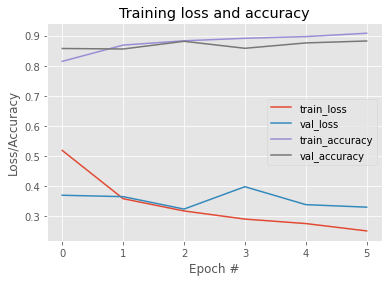

In [ ]:

'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 6)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HH.history['loss'], label='train_loss')
plt.plot(N, HH.history['val_loss'], label='val_loss')
plt.plot(N, HH.history['accuracy'], label='train_accuracy')
plt.plot(N, HH.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
ls

dataset/  drive/  intel-image-classification.zip  sample_data/


In [ ]:
# necessary imports
import os
import cv2
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [ ]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (150, 150))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [ ]:
ls drive/MyDrive/Colab\ Notebooks/CV/Date_Set/Data_Set/seg_pred/seg_pred/

buildings/  forest/  glacier/  mountain/  sea/  street/


In [ ]:
pred_data_path = "drive/MyDrive/Colab Notebooks/CV/Date_Set/Data_Set/seg_pred/seg_pred/"

In [ ]:
print('loading test images')
X_test, y_test = load_data(pred_data_path)

  0%|          | 0/1330 [00:00<?, ?it/s]

loading test images


100%|██████████| 1236/1236 [05:32<00:00,  3.72it/s]


In [ ]:
lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)

In [ ]:
y_test[0]

array([0, 0, 1, 0, 0, 0])

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

229/229 [==============================] - 15s 65ms/step - loss: 0.2800 - accuracy: 0.8962
Test Loss =  0.2800229489803314
Test Accuracy =  0.8961786031723022


In [ ]:

'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

In [ ]:
confusion_mtx

array([[1060,    2,    0,    0,    5,   77],
       [   5, 1112,    1,    2,    9,   37],
       [  16,    4,  693,  409,  194,   14],
       [  10,   10,   10, 1071,  181,   15],
       [   7,    2,    3,   17, 1081,   18],
       [  47,    1,    1,    1,    4, 1182]])